Part A asks to create an artificial 3D vector field with 2D horizontal vectors.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

Part B asks to create an artificial vector field. This will be a 3 dimensional field with 2d horizontal vecotors. The artificial vector field will be composed by creating a column vector that is copied to the other places. There will be two profiles selected, the log law and power law profiles. An Ekman spiral will also be added to the vector. Variation will be added with up to a random 10% "kick".

In [2]:
''' A 1 km square with a height of 300 meters is going to be used with a 1000 vertical point resolution.
The column vector will be a 1000 by 2 matrix. This is 1000 rows with 2 columns. Each row will the vector at a discrete height. The two columns will correspond to a u and v component of the vector.'''
height = 300 # number of meters in height
number_of_vertical_points = 1000 # resolution in meters
ColumnVecSize = (number_of_vertical_points,2) # size of column vector using the height and resolution
# Allocation of memory for column vector
ColumnVector_loglaw = np.zeros(ColumnVecSize, dtype=float) # float data type designation
z_location = np.linspace(0,height, number_of_vertical_points,dtype=float)


roughness_parameter = 0.01 # Common roughness parameter for crop/flat land region
Karman_const = 0.41 # Karman constant for log law
u_friction_velocity = 1.2 * Karman_const # number is picked to have Uinf close to 12 m/s
U_z = u_friction_velocity/Karman_const * np.log(z_location/roughness_parameter) # log law
U_z[0] = 0 # sets NaN part due to ln(0) to 0 at boundary

ColumnVector_loglaw[:,0] = U_z # assign U to the column vector U position

C:\Users\trevo\AppData\Local\Temp\ipykernel_44628\862430883.py:14: RuntimeWarning: divide by zero encountered in log
  U_z = u_friction_velocity/Karman_const * np.log(z_location/roughness_parameter) # log law


In [3]:
from EkmanSpiral import Ekman_Spiral
ColumnVector_loglaw_spiral = Ekman_Spiral(ColumnVector_loglaw,z_location) # add spiral component to field

In [4]:
import Create3DSpace
x, y, space = Create3DSpace.Space_Field(ColumnVector_loglaw_spiral, 300, 100)  # space is a 4d matrix defined as follows [x, y, z, vector selection (u=1 v=2)]. The last two dimensions are the original 

space_kicked = Create3DSpace.kick(space,0.05)# 5% random kick to each individual value

In [5]:
from Matlab_Import import LidarData, matlabimport
lidar_data = matlabimport()  # get matlab data
""" runs matlab import code. List is of object class lidarData which has a date, and 4 matrices named aximuth, elevation, rad_vector, and range. To access each set of lidar data use lidar_data.'name of variable matrix'
"""


" runs matlab import code. List is of object class lidarData which has a date, and 4 matrices named aximuth, elevation, rad_vector, and range. To access each set of lidar data use lidar_data.'name of variable matrix'\n"

In [6]:
import Slicing_and_Interp as SandI

elevation = np.array([75])  # set elevation of scan
number_of_scans = 80  # number of scans per range ring
azimuthals = np.reshape(np.linspace(0, 360, number_of_scans), (-1, 1))  # evenly spaced angles for azimuth rotation
lidar_location = np.array([x[50], y[50], 0])  # define lidar location
# create space for iterating variables
u_interp_val = np.zeros((len(z_location)-1, number_of_scans))  
v_interp_val = np.zeros((len(z_location)-1, number_of_scans))
x_lidar = np.zeros((len(z_location)-1, number_of_scans))
y_lidar = np.zeros((len(z_location)-1, number_of_scans))
z_lidar = np.zeros((len(z_location)-1, number_of_scans))

# loop for each horizontal plane, exclude 0 plane
for i in np.arange(1, len(z_location)):
    u_interp_val[i-1, :], v_interp_val[i-1, :], x_lidar[i-1, :], y_lidar[i-1, :], z_lidar[i-1, :] = SandI.slice_points(space_kicked, x, y, z_location, azimuthals, elevation, z_location[i], lidar_loc=lidar_location)

# space for projection iterables
laser_vect = np.zeros((np.size(x_lidar, axis=0), np.size(x_lidar, axis=1), 3)) 
laser_speed = np.zeros_like(x_lidar)

# loop to get speeds and laser vectors
for i in np.arange(np.size(laser_speed, axis=0)):
    measlocation = np.hstack((x_lidar[i, :].reshape((-1,1)), y_lidar[i, :].reshape((-1,1)), z_lidar[i, :].reshape((-1,1))))
    laser_vect[i, :, :], laser_speed[i, :] = SandI.vectorProjection(u_interp_val[i, :].T, v_interp_val[i, :].T, measlocation, lidar_location)
    
    

In [7]:
import VAD_Alg as VAD

lidar_VAD_loglaw = []  # space for VAD output vectors
# loop over each range ring
for i in range(np.size(laser_vect, axis=0)):
    VAD_output = VAD.vad_extraction(laser_vect[i, :, :], laser_speed[i, :].reshape(-1, 1))  # output vector for range ring, laser vector and laser speed inputted
    VAD_output_vect = VAD_output[0]  #VAD_output 0 is the output vector from least squares
    lidar_VAD_loglaw.append(VAD_output_vect)  #Add vector to storage list
    
    

C:\Users\trevo\PycharmProjects\MAE579\Wind Energy Project\HW3\VAD_Alg.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xhat = np.linalg.lstsq(normed_rad_vect, radial_velocity)  #Xhat is the closest projection of the vector space.


In [8]:
# actual points for plotting from space
u_actual_velocities_plot = space_kicked[50, 50, :, 0]
v_actual_velocities_plot = space_kicked[50, 50, :, 1]
z_actual_plot = z_location
# VAD measured points for plotting
z_measure_plot = z_location[1:]
lidar_VAD_loglaw_array = np.stack(lidar_VAD_loglaw, axis=0)
u_meas_plot = lidar_VAD_loglaw_array[:, 0]
v_meas_plot = lidar_VAD_loglaw_array[:, 1]

# angle calculation for both actual and VAD extraction
dir_actual = np.rad2deg(np.arctan(v_actual_velocities_plot/u_actual_velocities_plot))
dir_meas = np.rad2deg(np.arctan(v_meas_plot/u_meas_plot))


C:\Users\trevo\AppData\Local\Temp\ipykernel_44628\2432530481.py:9: RuntimeWarning: invalid value encountered in divide
  dir_actual = np.rad2deg(np.arctan(v_actual_velocities_plot/u_actual_velocities_plot))


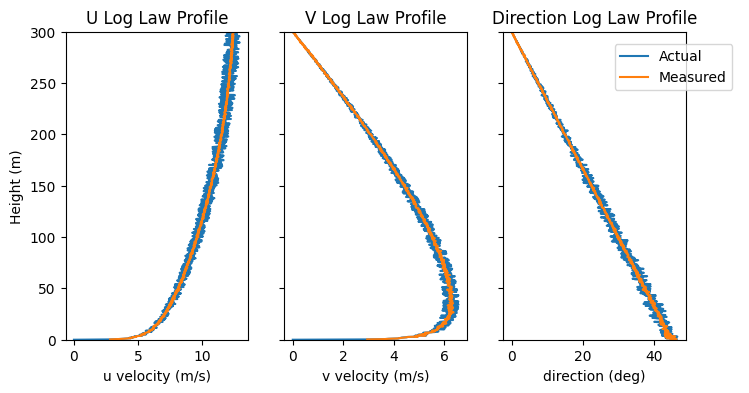

In [9]:
# Plotting for log law
fig_1, ax_1 = plt.subplots(figsize=(8, 4), nrows=1, ncols=3)
# plt.tight_layout()
ax_1[0].set_title('U Log Law Profile')
ax_1[1].set_title('V Log Law Profile')
ax_1[2].set_title('Direction Log Law Profile')
ax_1[0].set_ylabel('Height (m)')
ax_1[0].set_xlabel('u velocity (m/s)')
ax_1[1].set_xlabel('v velocity (m/s)')
ax_1[2].set_xlabel('direction (deg)')
ax_1[0].set_ylim([0, 300])
ax_1[1].set_ylim([0, 300])
ax_1[2].set_ylim([0, 300])
ax_1[1].yaxis.set_tick_params(labelleft=False)
ax_1[2].yaxis.set_tick_params(labelleft=False)

ax_1[0].plot(u_actual_velocities_plot,z_actual_plot, label='Actual')
ax_1[0].plot(u_meas_plot,z_measure_plot, label='Measured')
ax_1[1].plot(v_actual_velocities_plot,z_actual_plot, label='Actual')
ax_1[1].plot(v_meas_plot,z_measure_plot, label='Measured')
ax_1[2].plot(dir_actual,z_actual_plot, label='Actual')
ax_1[2].plot(dir_meas,z_measure_plot, label='Measured')

handles, labels = ax_1[0].get_legend_handles_labels()
fig_1.legend(handles, labels, loc=(0.82, 0.77))
fig_1.savefig('Artificial Wind Profile.png')

In [10]:
import lidar_preprocess as lipp
wind_vector = []
wind_meas_height = []
wind_meas_dir = []
# loop over each time stamp
for i in range(len(lidar_data)):
    lidar_extract_vector, lidar_z = lipp.lidar_vad_processing(lidar_data[i])
    wind_vector.append(lidar_extract_vector)
    wind_meas_height.append(lidar_z)
    wind_dir = np.rad2deg(np.arctan2(lidar_extract_vector[:, 1], lidar_extract_vector[:, 0]))
    wind_meas_dir.append(wind_dir)

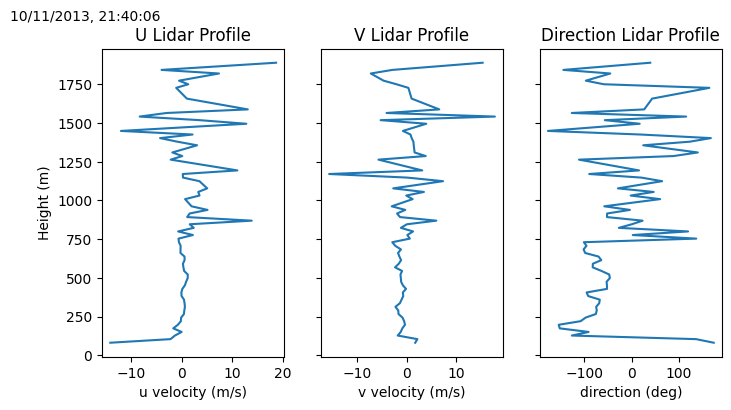

In [11]:
# lidar first day plot
fig_2, ax_2 = plt.subplots(figsize=(8, 4), nrows=1, ncols=3)
# plt.tight_layout()
ax_2[0].set_title('U Lidar Profile')
ax_2[1].set_title('V Lidar Profile')
ax_2[2].set_title('Direction Lidar Profile')
ax_2[0].set_ylabel('Height (m)')
ax_2[0].set_xlabel('u velocity (m/s)')
ax_2[1].set_xlabel('v velocity (m/s)')
ax_2[2].set_xlabel('direction (deg)')
# ax_2[0].set_ylim([0, 300])
# ax_2[1].set_ylim([0, 300])
# ax_2[2].set_ylim([0, 300])
ax_2[1].yaxis.set_tick_params(labelleft=False)
ax_2[2].yaxis.set_tick_params(labelleft=False)

ax_2[0].plot(wind_vector[0][:, 0],wind_meas_height[0], label='Actual')

ax_2[1].plot(wind_vector[0][:, 1],wind_meas_height[0], label='Actual')

ax_2[2].plot(wind_meas_dir[0],wind_meas_height[0], label='Actual')
text_data = plt.figtext(0.01, 0.95, lidar_data[0].date.strftime("%m/%d/%Y, %H:%M:%S"))

# fig_2.savefig('Lidar 1st plot.png')

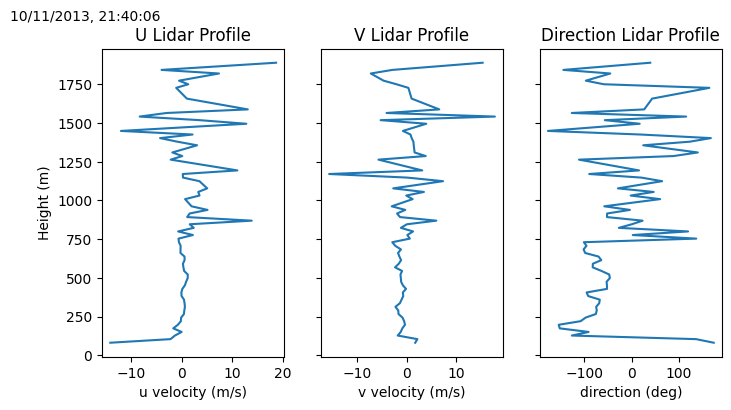

In [12]:
# lidar animation for u, v, and direction profiles
fig_3, ax_3 = plt.subplots(figsize=(8, 4), nrows=1, ncols=3)
# plt.tight_layout()
ax_3[0].set_title('U Lidar Profile')
ax_3[1].set_title('V Lidar Profile')
ax_3[2].set_title('Direction Lidar Profile')
ax_3[0].set_ylabel('Height (m)')
ax_3[0].set_xlabel('u velocity (m/s)')
ax_3[1].set_xlabel('v velocity (m/s)')
ax_3[2].set_xlabel('direction (deg)')
# ax_3[0].set_ylim([0, 300])
# ax_3[1].set_ylim([0, 300])
# ax_3[2].set_ylim([0, 300])
ax_3[1].yaxis.set_tick_params(labelleft=False)
ax_3[2].yaxis.set_tick_params(labelleft=False)

u_line = ax_3[0].plot(wind_vector[0][:, 0],wind_meas_height[0], label='Actual')
u_line = u_line[0]

v_line = ax_3[1].plot(wind_vector[0][:, 1],wind_meas_height[0], label='Actual')
v_line = v_line[0]

dir_line = ax_3[2].plot(wind_meas_dir[0],wind_meas_height[0], label='Actual')
dir_line = dir_line[0]

text_data = plt.figtext(0.01, 0.95, lidar_data[0].date.strftime("%m/%d/%Y, %H:%M:%S"))

import matplotlib.animation as animation


def update(frame):
    u_line.set_xdata(wind_vector[frame][:, 0])
    u_line.set_ydata(wind_meas_height[frame])
    v_line.set_xdata(wind_vector[frame][:, 1])
    v_line.set_ydata(wind_meas_height[frame])
    dir_line.set_xdata(wind_meas_dir[frame])
    dir_line.set_ydata(wind_meas_height[frame])
    text_data.set_text(lidar_data[frame].date.strftime("%m/%d/%Y, %H:%M:%S"))
    return u_line, v_line, dir_line

ani = animation.FuncAnimation(fig=fig_3, func=update, frames=515, interval=100)
ani.save(filename='wind profile progress.gif', writer="pillow")

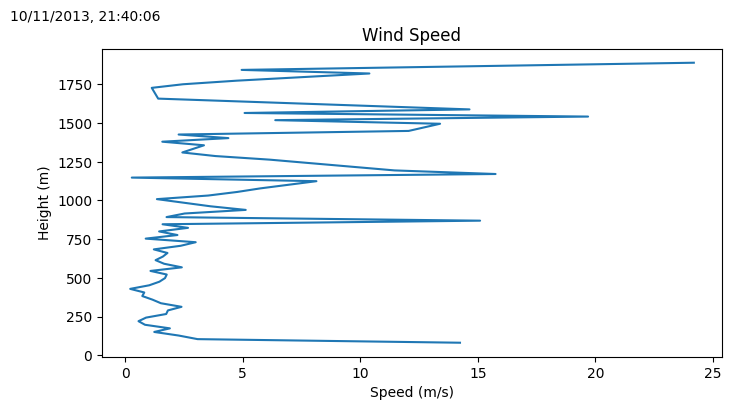

In [13]:
# animation for speed profile from lidar
fig_4, ax_4 = plt.subplots(figsize=(8, 4))
# plt.tight_layout()
ax_4.set_title('Wind Speed')

ax_4.set_ylabel('Height (m)')
ax_4.set_xlabel('Speed (m/s)')

speed = np.sqrt((wind_vector[0][:, 0] **2 + wind_vector[0][:, 1] **2))

u_line = ax_4.plot(speed,wind_meas_height[0], label='Actual')
u_line = u_line[0]


text_data = plt.figtext(0.01, 0.95, lidar_data[0].date.strftime("%m/%d/%Y, %H:%M:%S"))

import matplotlib.animation as animation


def update(frame):
    speed_update = np.sqrt((wind_vector[frame][:, 0] ** 2 + wind_vector[frame][:, 1] ** 2))
    u_line.set_xdata(speed_update)
    u_line.set_ydata(wind_meas_height[frame])
    
    text_data.set_text(lidar_data[frame].date.strftime("%m/%d/%Y, %H:%M:%S"))
    return u_line

ani = animation.FuncAnimation(fig=fig_4, func=update, frames=515, interval=100)
ani.save(filename='wind speed.gif', writer="pillow")

In [14]:
# Power law parameters
alpha = 1/7  # Power law parameter
U_inf = 12.0  # Reference wind speed
z_ref = 300  # Reference height
number_of_vertical_points = 1000

# Create a column vector
ColumnVecSize = (number_of_vertical_points, 2)
z_location = np.linspace(0, z_ref, number_of_vertical_points, dtype=float)

# Generate power law profile
U_powerlaw = U_inf * (z_location / z_ref) ** alpha

# Create a new column vector for power law
ColumnVector_powerlaw = np.zeros(ColumnVecSize, dtype=float)
ColumnVector_powerlaw[:, 0] = U_powerlaw  # Assign the power law profile to the u component, v = 0.

# Add Ekman spiral component
ColumnVector_powerlaw_spiral = Ekman_Spiral(ColumnVector_powerlaw, z_location)

# Create 3D space
x_powerlaw, y_powerlaw, space_powerlaw = Create3DSpace.Space_Field(ColumnVector_powerlaw_spiral, 300, 100 )


C:\Users\trevo\PycharmProjects\MAE579\Wind Energy Project\HW3\VAD_Alg.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xhat = np.linalg.lstsq(normed_rad_vect, radial_velocity)  #Xhat is the closest projection of the vector space.
C:\Users\trevo\AppData\Local\Temp\ipykernel_44628\602436036.py:47: RuntimeWarning: invalid value encountered in divide
  dir_actual = np.rad2deg(np.arctan(v_actual_velocities_plot / u_actual_velocities_plot))


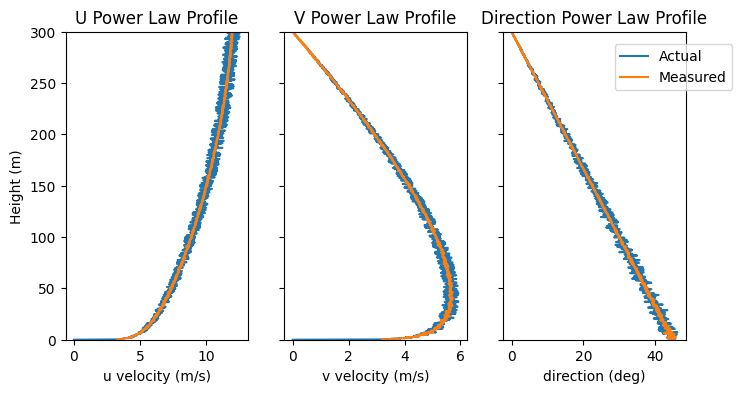

In [15]:
space_k_powl = Create3DSpace.kick(space_powerlaw,
                                  np.array([5 / 100], dtype=float))  # 5% random kick to each individual value
space_k_powl = Create3DSpace.kick(space_powerlaw, 0.05)
elevation = np.array([75])  # set elevation of scan, angle from ground
number_of_scans = 80  # number of scans per range ring
azimuthals = np.reshape(np.linspace(0, 360, number_of_scans), (-1, 1))  # evenly spaced angles for azimuth rotation
lidar_location = np.array([x_powerlaw[50], y_powerlaw[50], 0])  # define lidar location
# create space for iterating variables, creating vectors of 0 with the length zloc-1
u_interp_val = np.zeros((len(z_location) - 1, number_of_scans))
v_interp_val = np.zeros((len(z_location) - 1, number_of_scans))
x_lidar = np.zeros((len(z_location) - 1, number_of_scans))
y_lidar = np.zeros((len(z_location) - 1, number_of_scans))
z_lidar = np.zeros((len(z_location) - 1, number_of_scans))

# loop for each horizontal plane, exclude 0 plane
for i in np.arange(1, len(z_location)):
    u_interp_val[i - 1, :], v_interp_val[i - 1, :], x_lidar[i - 1, :], y_lidar[i - 1, :], z_lidar[i - 1,
                                                                                          :] = SandI.slice_points(
        space_k_powl, x_powerlaw, y_powerlaw, z_location, azimuthals, elevation, z_location[i],
        lidar_loc=lidar_location)

# creating space for projection iterables, size needs to be as long as the lidar data.
laser_vect = np.zeros((np.size(x_lidar, axis=0), np.size(x_lidar, axis=1), 3))
laser_speed = np.zeros_like(x_lidar)

# loop to get speeds and laser vectors
for i in np.arange(np.size(laser_speed, axis=0)):
    measlocation = np.hstack(
        (x_lidar[i, :].reshape((-1, 1)), y_lidar[i, :].reshape((-1, 1)), z_lidar[i, :].reshape((-1, 1))))
    laser_vect[i, :, :], laser_speed[i, :] = SandI.vectorProjection(u_interp_val[i, :].T, v_interp_val[i, :].T,
                                                                    measlocation, lidar_location)

lidar_VAD_Powerlaw = []
for i in range(np.size(laser_vect, axis=0)):
    VAD_output = VAD.vad_extraction(laser_vect[i, :, :], laser_speed[i, :].reshape(-1, 1))
    VAD_output_vect = VAD_output[0]
    lidar_VAD_Powerlaw.append(VAD_output_vect)

u_actual_velocities_plot = space_k_powl[50, 50, :, 0]
v_actual_velocities_plot = space_k_powl[50, 50, :, 1]
z_actual_plot = z_location
z_measure_plot = z_location[1:]
lidar_VAD_Powerlaw_array = np.stack(lidar_VAD_Powerlaw, axis=0)
u_meas_plot = lidar_VAD_Powerlaw_array[:, 0]
v_meas_plot = lidar_VAD_Powerlaw_array[:, 1]

dir_actual = np.rad2deg(np.arctan(v_actual_velocities_plot / u_actual_velocities_plot))
dir_meas = np.rad2deg(np.arctan(v_meas_plot / u_meas_plot))

fig_5, ax_5 = plt.subplots(figsize=(8, 4), nrows=1, ncols=3)
# plt.tight_layout()
ax_5[0].set_title('U Power Law Profile')
ax_5[1].set_title('V Power Law Profile')
ax_5[2].set_title('Direction Power Law Profile')
ax_5[0].set_ylabel('Height (m)')
ax_5[0].set_xlabel('u velocity (m/s)')
ax_5[1].set_xlabel('v velocity (m/s)')
ax_5[2].set_xlabel('direction (deg)')
ax_5[0].set_ylim([0, 300])
ax_5[1].set_ylim([0, 300])
ax_5[2].set_ylim([0, 300])
ax_5[1].yaxis.set_tick_params(labelleft=False)
ax_5[2].yaxis.set_tick_params(labelleft=False)

ax_5[0].plot(u_actual_velocities_plot, z_actual_plot, label='Actual')
ax_5[0].plot(u_meas_plot, z_measure_plot, label='Measured')
ax_5[1].plot(v_actual_velocities_plot, z_actual_plot, label='Actual')
ax_5[1].plot(v_meas_plot, z_measure_plot, label='Measured')
ax_5[2].plot(dir_actual, z_actual_plot, label='Actual')
ax_5[2].plot(dir_meas, z_measure_plot, label='Measured')

handles, labels = ax_5[0].get_legend_handles_labels()
fig_5.legend(handles, labels, loc=(0.82, 0.77))
fig_5.savefig('Artificial Wind Profile_02.png')